In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.svm import SVC
import pylab
import time
import random
import matplotlib.pyplot as plt


# Monitor marginal density vs accuracy for support vector classifier

In [2]:
df = pd.read_csv('data/elecNormNew.csv', names = ['feature1','feature2','feature3',
                                                  'feature4','feature5','feature6',
                                                  'feature7','feature8','label'])

In [3]:
def calc_marginal_density(model,X,y):
    w = model.coef_
    w = w.reshape(X.shape[1],)
    b = model.intercept_
    dp = abs(np.dot(X,w)+b)
    rho  = np.round(np.array(dp<1).sum() / X.shape[0],7)
    return rho

In [4]:
def train_model(X,y):
    seed = 369
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    model_new = SVC(kernel = 'linear')
    model_new.fit(X_train, y_train)
    y_pred = model_new.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy after retraining: %.2f%%" % (accuracy * 100.0))
    return model_new,X_test

In [5]:
df1 = df[0:15000]
X1 = df1[['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8']].values
y1 = df1['label'].values
label = ["UP", "DOWN"]
le = preprocessing.LabelEncoder()
le.fit(label)
y1 = le.transform(y1)
# split data into train and test sets
seed = 9
test_size = 0.33
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=seed)
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
# fit model no training data
model = SVC(kernel = 'linear')
model.fit(X1_train, y1_train)
print(model)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [6]:
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=4369)
cv_results = model_selection.cross_validate(model, X1_train, y1_train, cv=kfold, scoring=scoring)
clf = model.fit(X1_train, y1_train)
cv_results

{'fit_time': array([1.5820539 , 1.56004763, 1.51200962, 1.67711997, 1.81401396]),
 'score_time': array([0.1390059 , 0.13611388, 0.1430068 , 0.14704919, 0.17306256]),
 'test_accuracy': array([0.81044776, 0.8159204 , 0.80746269, 0.80696517, 0.80597015]),
 'test_precision_weighted': array([0.81291083, 0.81833889, 0.80944653, 0.80855509, 0.8103257 ]),
 'test_recall_weighted': array([0.81044776, 0.8159204 , 0.80746269, 0.80696517, 0.80597015]),
 'test_f1_weighted': array([0.80853436, 0.81342901, 0.8055209 , 0.80507055, 0.80372846]),
 'test_roc_auc': array([0.89668858, 0.90308424, 0.89106187, 0.88532714, 0.8874041 ])}

In [7]:
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=4369)
cv_results = model_selection.cross_validate(model, X1_train, y1_train, cv=kfold, scoring=calc_marginal_density)
clf = model.fit(X1_train, y1_train)
cv_results

{'fit_time': array([1.70208955, 1.67505383, 1.6410563 , 2.14207458, 2.56360435]),
 'score_time': array([0.00303316, 0.        , 0.        , 0.        , 0.        ]),
 'test_score': array([0.639801 , 0.6288557, 0.6283582, 0.6492537, 0.6338308])}

In [8]:
sigma_ref = cv_results['test_score'].std()

In [9]:
sigma_ref

0.00780063775582485

## Monitor marginal density with changing data set

In [10]:

# %matplotlib notebook
# import numpy as np
# import matplotlib.pyplot as plt

In [11]:
## Initiate model
df1 = df[0:5000]
X1 = df1[['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8']].values
y1 = df1['label'].values
label = ["UP", "DOWN"]
le = preprocessing.LabelEncoder()
le.fit(label)
y1 = le.transform(y1)
# split data into train and test sets
seed = 9
test_size = 0.33
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=seed)
# fit model no training data
# model = SVC(kernel = 'linear' , C = 2, probability = True)
model = SVC(kernel = 'linear')
model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print("Initial model accuracy: %.2f%%" % (accuracy * 100.0))

Initial model accuracy: 80.06%


In [12]:
print('initial marginal density ' , calc_marginal_density(model,X1,y1))

initial marginal density  0.6192


C:\Users\t910571\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


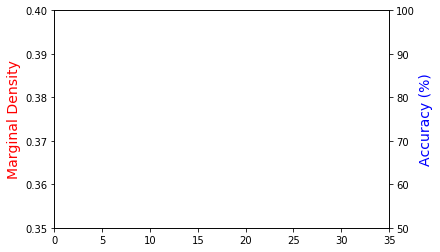

In [13]:
batch_size = 1000
window_size = 10000
# fig = plt.figure(figsize=(10,20))
fig = plt.figure()
ax  = fig.add_subplot(111)
ax2=ax.twinx()
plt.ion()

fig.show()
fig.canvas.draw()

densities = []
acc = []
# rho_max = rho_min
for i in range(int((len(df)-1)/batch_size)+1):
    df_temp = df[(i*batch_size):((i*batch_size)+window_size)]
    X2 = df_temp[['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8']].values
    y2 = df_temp['label'].values
    label = ["UP", "DOWN"]
    le = preprocessing.LabelEncoder()
    le.fit(label)
    y2 = le.transform(y2)
    rho = calc_marginal_density(model,X2,y1)
#     if  (rho > rho_max):
#         rho_max = rho
    
#     densities.append(rho_max -rho_min)
    densities.append(rho)
    y2_pred = model.predict(X2)
#     print(accuracy_score(y2, y2_pred))
    acc.append((100*accuracy_score(y2, y2_pred)))
    ax.clear()
#     ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax2.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax.set_ylim([0.35,0.4])
    ax2.set_ylim([50,100])
    ax.plot(range(len(densities)),densities, color = 'red')
    ax.set_ylabel("Marginal Density",color="red",fontsize=14)
    ax2.plot(range(len(acc)),acc, color = 'blue')
    ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)

    fig.canvas.draw()
    plt.pause(0.0000001)
    

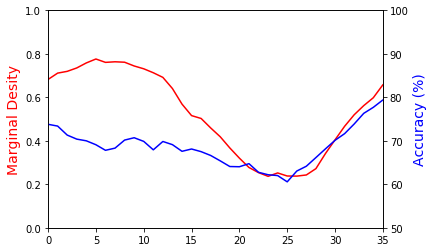

In [14]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax2=ax.twinx()
ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
ax2.set_xlim([0,int((len(df)-window_size)/batch_size)])
ax.set_ylim([0,1])
ax2.set_ylim([50,100])
ax.plot(range(len(densities)),densities, color = 'red')
ax.set_ylabel("Marginal Desity",color="red",fontsize=14)
ax2.plot(range(len(acc)),acc, color = 'blue')
ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)
plt.savefig('figs/MD3_wo_intervention_NSW.png')

In [15]:
np.mean(acc)

70.51485777362953

## Monitor accuracy with intervention at $| \rho_{train} - \rho_{score} | > 0.25 * \sigma_{ref}$ 

Initial model accuracy: 81.39%


C:\Users\t910571\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


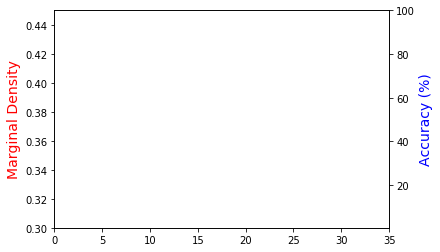

Accuracy after retraining: 80.82%
Accuracy after retraining: 82.61%
Accuracy after retraining: 81.61%
Accuracy after retraining: 82.39%
Accuracy after retraining: 81.12%
Accuracy after retraining: 80.58%
Accuracy after retraining: 80.15%
Accuracy after retraining: 78.79%
Accuracy after retraining: 79.00%
Accuracy after retraining: 77.45%
Accuracy after retraining: 78.36%
Accuracy after retraining: 74.94%
Accuracy after retraining: 79.15%
Accuracy after retraining: 77.48%
Accuracy after retraining: 75.91%
Accuracy after retraining: 75.21%
Accuracy after retraining: 73.67%
Accuracy after retraining: 73.67%
Accuracy after retraining: 73.76%
Accuracy after retraining: 72.24%
Accuracy after retraining: 71.33%
Accuracy after retraining: 72.52%
Accuracy after retraining: 69.52%
Accuracy after retraining: 69.97%
Accuracy after retraining: 70.64%
Accuracy after retraining: 68.70%
Accuracy after retraining: 65.48%
Accuracy after retraining: 64.94%
Accuracy after retraining: 67.09%
Accuracy after

In [16]:
batch_size = 1000
window_size = 10000
## Initiate model
df1 = df[0:15000]
X1 = df1[['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8']].values
y1 = df1['label'].values
label = ["UP", "DOWN"]
le = preprocessing.LabelEncoder()
le.fit(label)
y1 = le.transform(y1)
# split data into train and test sets
seed = 9
test_size = 0.33
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=seed)
# fit model no training data
model = SVC(kernel = 'linear')
model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print("Initial model accuracy: %.2f%%" % (accuracy * 100.0))

rho_min = calc_marginal_density(model,X1,y1)


# fig = plt.figure(figsize=(10,20))
fig = plt.figure()
ax  = fig.add_subplot(111)
ax2=ax.twinx()
plt.ion()

fig.show()
fig.canvas.draw()

densities = []
acc = []
for i in range(int((len(df)-window_size)/batch_size)+1):

    df_temp = df[(i*batch_size):((i*batch_size)+window_size)]
    X2 = df_temp[['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8']].values
    y2 = df_temp['label'].values
    label = ["UP", "DOWN"]
    le = preprocessing.LabelEncoder()
    le.fit(label)
    y2 = le.transform(y2)
#     PSIs.append(calculate_PSI(X1_test,df[i*batch_size,(i*batch_size)+window_size],model))
    rho = calc_marginal_density(model,X2,y1)
    densities.append(rho)
    y2_pred = model.predict(X2)
#     print((100*accuracy_score(y2, y2_pred)))
    acc.append((100*accuracy_score(y2, y2_pred)))
    ax.clear()
    ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax2.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax.set_ylim([0.30,0.45])
    ax2.set_ylim([0.4,100])
    ax.plot(range(len(densities)),densities, color = 'red')
    ax.set_ylabel("Marginal Density",color="red",fontsize=14)
    ax2.plot(range(len(acc)),acc, color = 'blue')
    ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)

    fig.canvas.draw()
    plt.pause(0.001)
    
    if abs(rho-rho_min) > (0.25*sigma_ref):
#         print("Condition met, retraining model")
        model,new_ref_df = train_model(X2,y2)
#         print("new PSI = ", calculate_PSI(X2,X2,model))
        X1_test = X2
#         rho_min = calc_marginal_density(model,X2,y)
   
        

        

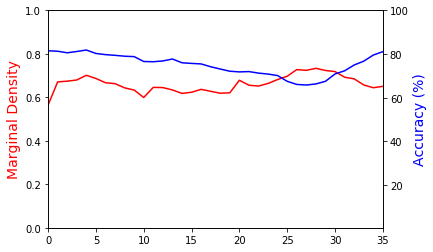

In [17]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax2=ax.twinx()
ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
ax2.set_xlim([0,int((len(df)-window_size)/batch_size)])
ax.set_ylim([0,1])
ax2.set_ylim([0.4,100])
ax.plot(range(len(densities)),densities, color = 'red')
ax.set_ylabel("Marginal Density",color="red",fontsize=14)
ax2.plot(range(len(acc)),acc, color = 'blue')
ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)
plt.savefig('figs/MD3_w_intervention_NSW.png')

In [18]:
np.mean(acc)

75.06416666666667

In [19]:
acc

[81.5,
 81.28,
 80.57,
 81.16,
 81.83,
 80.25999999999999,
 79.72,
 79.4,
 79.0,
 78.81,
 76.57000000000001,
 76.47,
 76.83,
 77.71000000000001,
 75.99000000000001,
 75.7,
 75.46000000000001,
 74.17,
 73.13,
 72.11999999999999,
 71.81,
 71.96000000000001,
 71.25,
 70.82000000000001,
 70.12,
 67.5,
 66.07,
 65.8,
 66.3,
 67.51,
 70.87,
 72.31,
 74.97,
 76.72,
 79.53,
 81.08999999999999]